# Genetic Algorithm based Robot Parameters tuning

## 0 Imports

In [1]:
import os
import tqdm
import bagpy
import pygad
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## 1 Bag reading and content assessment

In [2]:
b = bagpy.bagreader('./bags_new/bag3.bag')
# get the list of topics
print(b.topic_table)
# get all the messages of all topics
csvfiles = []
for t in b.topics:
    data = b.message_by_topic(t)
    csvfiles.append(data)

poses = pd.read_csv(csvfiles[0])
wheel_states = pd.read_csv(csvfiles[1])
print(wheel_states)
poses

[INFO]  Data folder ./bags_new/bag3 already exists. Not creating.
          Topics                      Types  Message Count   Frequency
0    /robot/pose  geometry_msgs/PoseStamped          17799  174.421092
1  /wheel_states     sensor_msgs/JointState           5149   48.976564
              Time  header.seq  header.stamp.secs  header.stamp.nsecs  \
0     1.649349e+09           1         1649348785            31191825   
1     1.649349e+09           2         1649348785            51174163   
2     1.649349e+09           3         1649348785            71672916   
3     1.649349e+09           4         1649348785            92028141   
4     1.649349e+09           5         1649348785           112309455   
...            ...         ...                ...                 ...   
5144  1.649349e+09        5145         1649348890           272181749   
5145  1.649349e+09        5146         1649348890           292039871   
5146  1.649349e+09        5147         1649348890           3133

,Time,header.seq,header.stamp.secs,header.stamp.nsecs,header.frame_id,pose.position.x,pose.position.y,pose.position.z,pose.orientation.x,pose.orientation.y,pose.orientation.z,pose.orientation.w
0,1.649349e+09,185006,1649348784,993775398,world,0.005460,0.039970,0.370361,-0.010593,-0.024768,-0.006752,0.999614
1,1.649349e+09,185007,1649348785,2962371,world,0.005272,0.039899,0.370252,-0.008938,-0.016773,0.000029,0.999819
2,1.649349e+09,185008,1649348785,4231558,world,0.005701,0.040275,0.370213,-0.007415,-0.024286,-0.007835,0.999647
3,1.649349e+09,185009,1649348785,11670943,world,0.005472,0.039882,0.370159,-0.010821,-0.022694,-0.001732,0.999682
4,1.649349e+09,185010,1649348785,17029274,world,0.005541,0.039964,0.370194,-0.009629,-0.023609,-0.003327,0.999669
...,...,...,...,...,...,...,...,...,...,...,...,...
17794,1.649349e+09,202800,1649348890,313442892,world,-0.005280,0.023007,0.370406,0.018180,-0.043580,-0.000276,0.998884
17795,1.649349e+09,202801,1649348890,318506406,world,-0.005190,0.021783,0.371000,0.005611,-0.039376,-0.001610,0.999207
17796,1.649349e+09,202802,1649348890,323936490,world,-0.005728,0.023108,0.371193,0.016323,-0.050367,0.000637,0.998597
17797,1.649349e+09,202803,1649348890,330557147,world,-0.005387,0.022606,0.370996,-0.011536,-0.002539,-0.000360,0.999930


## 2 Trajectory computation and display

In [3]:
def compute_trajectory(wheel_states, poses, r=0.07, l=0.2, w=0.169, N=42, use_ticks=True, euler=True):
    '''The function generates the ODOMETRY-based trajectory of the robot, given the initial state <x,y,th>
    taken from the optitrack ground-truth trajectory. This way, the odometry trajectories lie in the same
    reference system as the optitrack one and are comparable.
    The ticks variable (position) in the odometry represent the number of tick from the absolute beginning
    of the encoder recording! Not the realtime position of the wheel. It's basically a counter.
    :param wheel_states: the odometry data, in actuality the encoders are on the motor of the robot
    :param poses: the ground truth poses of the robot given by the optitrack system
    :param r: the radius of the wheels
    :param l: half length of the robot
    :param w: half width of the robot
    :param N: number of ticks on the encoders on the robot motor
    :param use_ticks: whether to use ticks to compute the trajectory or directly use the motor velocity
    recorded in the bags
    :param euler: if true, Euler formula is used to compute the new position, else Runge-Kutta one is used
    :returns: the trajectory as ndarray (num_points, 3) of the states <x,y,th>
    '''
    T = 5 #Gear ratio
    
    # Must be equal to the initial pose! They must "look" in same direction to compare trajectories!
    x = poses['pose.position.x'][0]
    y = poses['pose.position.y'][0]
    theta = poses['pose.orientation.z'][0]
    pose_arr = np.array([[x,y,theta]])

    for i in range(1, len(wheel_states)):
        dt = wheel_states['Time'][i] - wheel_states['Time'][i-1]

        # Wheel ANGULAR VELOCITY, radians/second. In the bag it is radians/minute
        if use_ticks:
            wheel0_rps = 2*np.pi*(wheel_states['position_0'][i] - wheel_states['position_0'][i-1]) / (T * N * dt)
            wheel1_rps = 2*np.pi*(wheel_states['position_1'][i] - wheel_states['position_1'][i-1]) / (T * N * dt)
            wheel2_rps = 2*np.pi*(wheel_states['position_2'][i] - wheel_states['position_2'][i-1]) / (T * N * dt)
            wheel3_rps = 2*np.pi*(wheel_states['position_3'][i] - wheel_states['position_3'][i-1]) / (T * N * dt)
        else:
            wheel0_rps = wheel_states['velocity_0'][i] / 60 / T
            wheel1_rps = wheel_states['velocity_1'][i] / 60 / T
            wheel2_rps = wheel_states['velocity_2'][i] / 60 / T
            wheel3_rps = wheel_states['velocity_3'][i] / 60 / T

        # vx, vy, w
        lin_vel_x = (r / 4) * (wheel0_rps + wheel1_rps + wheel2_rps + wheel3_rps)
        lin_vel_y = (r / 4) * (-wheel0_rps + wheel1_rps + wheel2_rps - wheel3_rps)
        ang_vel = (r / 4) * (1 / (l + w)) * (-wheel0_rps + wheel1_rps - wheel2_rps + wheel3_rps)

        # Odom
        delta_x = lin_vel_x * dt
        delta_y = lin_vel_y * dt
        delta_theta = ang_vel * dt

        if euler: # Euler
            x += delta_x * np.cos(theta) - delta_y * np.sin(theta)
            y += delta_x * np.sin(theta) + delta_y * np.cos(theta)
        else: # Runge-Kutta
            x += delta_x * np.cos(theta + ang_vel * dt / 2) - delta_y * np.sin(theta + ang_vel * dt / 2)
            y += delta_x * np.sin(theta + ang_vel * dt / 2) + delta_y * np.cos(theta + ang_vel * dt / 2)
        theta += delta_theta
        
        pose_arr = np.concatenate((pose_arr, np.array([[x,y,theta]])), axis=0)
    return pose_arr

Default parameters trajectory


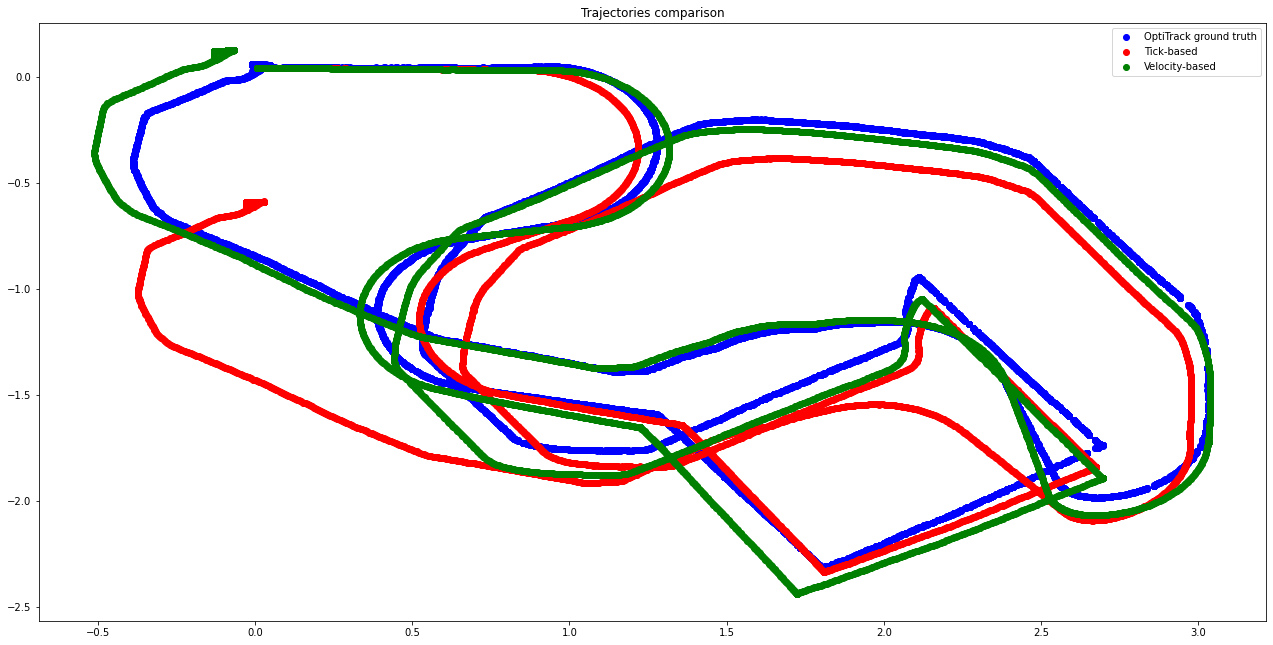

Optimized parameters trajectory


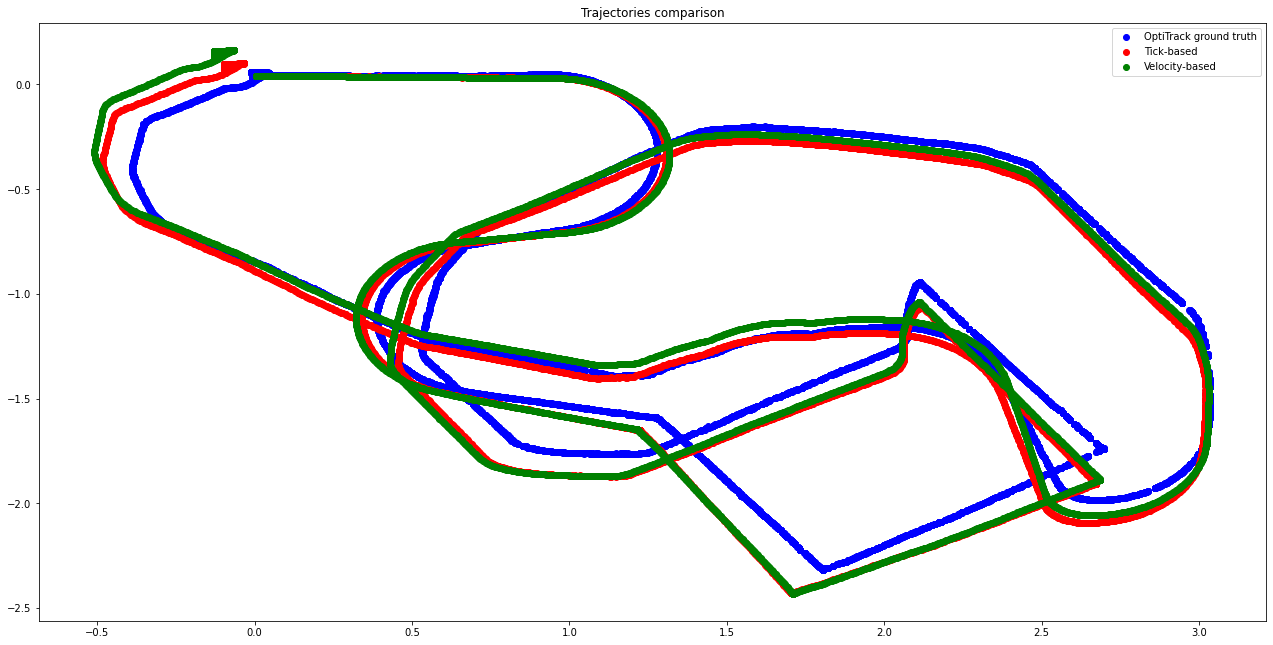

In [4]:
def plot_trajectories(r=0.07, l=0.2, w=0.169, N=42, for_save=False):
    '''Plots the ground truth, ticks-based, velocity-based trajectories
    :param r: the radius of the wheels
    :param l: half length of the robot
    :param w: half width of the robot
    :param N: number of ticks on the encoders on the robot motor
    '''
    fig = plt.figure(figsize=(22,11))
    plt.title('Trajectories comparison')

    ground_truth_traj = poses[['pose.position.x', 'pose.position.y']].to_numpy()
    plt.scatter(ground_truth_traj[:,0], ground_truth_traj[:,1], color='blue', label='OptiTrack ground truth')

    pose_arr = compute_trajectory(wheel_states, poses, r=r, l=l, w=w, N=N, use_ticks=True)
    plt.scatter(pose_arr[:,0],pose_arr[:,1], color='red', label='Tick-based')

    pose_arr = compute_trajectory(wheel_states, poses, r=r, l=l, w=w, N=N, use_ticks=False)
    plt.scatter(pose_arr[:,0],pose_arr[:,1], color='green', label='Velocity-based')
    
    plt.legend()
    if not for_save: plt.show()

def save_trajectories(solutions):
    '''Saves the images of the best trajectories of every epoch.
    :param solutions: the numpy ndarray of the solutions
    '''
    if not os.path.exists('saves/'): os.makedirs('saves/')
    for i,sol in enumerate(solutions):
        r, l, w, N = sol
        plot_trajectories(r, l, w, N, for_save=True)
        plt.savefig('saves/traj_'+str(i)+'.png')
        plt.close()

# Optimized params
r=0.07007972256976944
l=0.19943134513875557
w=0.1680582071314848
N=38

print('Default parameters trajectory')
plot_trajectories()

print('Optimized parameters trajectory')
plot_trajectories(r, l, w, N)

## 3 Losses and regularization definition

In [5]:
def compute_avg_dist(ground_truth_traj, traj, n_points=500):
    '''LOSS
    The algorithm computes the average distance between n_points of the points of the ground truth
    trajectory and their closest point in the trajectory traj.
    Timestamps cannot be used because optitrack is supposed not to be reliable (the rilevations may have
    lag or unwanted behaviors)
    :param ground_truth_traj: numpy ndarray (num_points, 2), (x,y) positions, ground truth trajectory
    :param traj: numpy ndarray (num_points, 3), (x,y,th) positions, traj to compute the avg dist with ground truth
    :param n_points: number of points to sample from ground truth, the algorithm computes the average
                     distance between these points and the closest point of the trajectory traj
    '''
    step = len(ground_truth_traj) // n_points # step between one point and the next to extract n_points
    
    # Sample n_points from ground truth
    error = 0
    for i in range(0, len(ground_truth_traj), step):
        pt_ground_truth = ground_truth_traj[i,:2]
        # Compute distance of closest point in traj
        l2_dist = np.sqrt(np.sum(np.square(traj[:,:2] - pt_ground_truth), axis=1))
        min_dist = np.min(l2_dist) # distance of the closest point
        error += min_dist
    
    # Average distance - error
    error = error / n_points
    return error

def compute_params_loss(r_sol, l_sol, w_sol, N_sol):
    '''REGULARIZATION
    Allows to regularize the parameters computing their relative distance from the original.
    This allows to give the same importance to all parameters, regardless of the scale.
    :param r_sol: r, solution found by the GA
    :param l_sol: l, solution found by the GA
    :param w_sol: w, solution found by the GA
    :param N_sol: N, solution found by the GA
    '''
    r = 0.07
    l = 0.2
    w = 0.169
    N = 42
    # Compute relative change wrt default parameters, which does not depend on scale
    r_dist = np.abs(r_sol-r)/r
    l_dist = np.abs(l_sol-l)/l
    w_dist = np.abs(w_sol-w)/w
    N_dist = np.abs(N_sol-N)/N
    return r_dist + l_dist + w_dist + N_dist

## 4 Fitness definition and GA optimization

Train params with GA, do JOINT OPTIMIZATION of both the TICKS traj and the VELOCITY traj in order to better constrain the problem and not let the parameters explode.

Optimizing the velocity trajectory too (since it is fairly correct with the default parameters) acts as another form of regularization on the optimization process.

Also directly use regularization, which penalizes the relative distance of the solution from the predefined values.

  0%|                                                                                          | 0/200 [00:00<?, ?it/s]C:\Users\aless\anaconda3\envs\ros_env\lib\site-packages\pygad\pygad.py:787: UserWarning: Use the 'save_best_solutions' parameter with caution as it may cause memory overflow when either the number of generations or number of genes is large.
  if not self.suppress_warnings: warnings.warn("Use the 'save_best_solutions' parameter with caution as it may cause memory overflow when either the number of generations or number of genes is large.")
100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [17:00<00:00,  5.10s/it]


Parameters of the best solution: [0.06946970996058974 0.2004690637412597 0.16438153159232027 38]
Fitness value of the best solution: 21.167800867961894


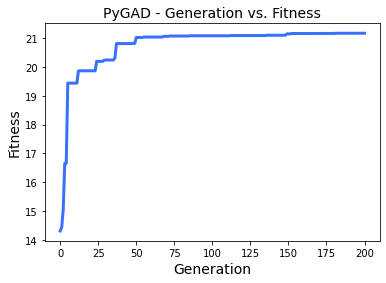

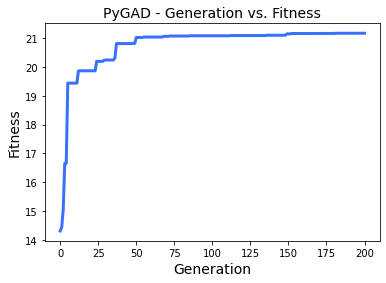

In [6]:
ground_truth_traj = poses[['pose.position.x', 'pose.position.y']].to_numpy()

def fitness_func(solution, solution_idx):
    '''The fitness function uses three components: error of the ticks-based trajectory, error of the
    velocity-based trajectory, regularization.
    Parameters to optimize: [r, l, w, N]
    '''
    reg = 0.04 #coefficient for the regularization
    alpha = 0.49 #coefficient of the ticks-based trajectory loss
    beta = 1-(alpha+reg) #coefficient of the velocity-based trajectory loss
    
    r, l, w, N = solution
    
    traj_ticks = compute_trajectory(wheel_states, poses, r=r, l=l, w=w, N=N, use_ticks=True)
    error_ticks = compute_avg_dist(ground_truth_traj, traj_ticks)
    
    traj_vel = compute_trajectory(wheel_states, poses, r=r, l=l, w=w, N=N, use_ticks=False)
    error_vel = compute_avg_dist(ground_truth_traj, traj_vel)
    
    params_reg = compute_params_loss(r, l, w, N)
    
    loss = (alpha*error_ticks + beta*error_vel + reg*params_reg)
    fitness = 1.0 / (loss + 0.00000001)
    return fitness



num_generations = 200
with tqdm.tqdm(total=num_generations) as pbar:
    ga_instance = pygad.GA(num_generations=num_generations,
                           num_parents_mating=2,
                           fitness_func=fitness_func,
                           sol_per_pop=8,
                           num_genes=4,
                           # Parameters type
                           gene_type= [float, float, float, int],
                           # Accomodate up to 1/2 cm of error
                           gene_space=[{'low':0.06, 'high':0.08},{'low':0.18, 'high':0.22},
                                       {'low':0.149, 'high':0.189},{'low':37, 'high':47}],
                           init_range_low=0.05,
                           init_range_high=40,
                           parent_selection_type="sss",
                           keep_parents=1,
                           crossover_type="single_point",
                           mutation_type="random",
                           mutation_percent_genes=25,
                           on_generation=lambda _: pbar.update(1),
                           save_best_solutions=True)
    ga_instance.run()


solution, solution_fitness, solution_idx = ga_instance.best_solution()
print('Parameters of the best solution:', solution)
print('Fitness value of the best solution:', solution_fitness)

ga_instance.plot_fitness()

In [7]:
ga_instance.best_solutions.shape

(201, 4)

In [8]:
save_trajectories(ga_instance.best_solutions)

Optimization results

On bag3:
[0.07007972256976944 0.19943134513875557 0.1680582071314848 38]

On bag2:
[0.06536492560924695 0.18250185337017752 0.16515443675414418 37]

On bag1:
[0.06920374362066399 0.19992610213463496 0.16913026877649368 38]

On bag3 with no regularization:
[0.0700368088348283 0.1812399329620913 0.18574904307836762 38]

On bag3, only ticks traj, no regularization:
[0.0741724672229785 0.21703677215432898 0.1505364868836153 40]

On bag3, runge_kutta formula:
[0.07000368971853796 0.1982552530497264 0.16831249374233373 38]